## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image
from copy import deepcopy


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from utils import *

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance 
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression


import warnings
warnings.filterwarnings('ignore')




# Part 1

## Load Data

In [2]:
# Data paths
labeled_data_path = '../data/data_labeled/'
unlabeled_data_path = '../data/data_unlabeled/'

# Image paths
img_test_unlabeled_path = '../data/data_labeled/Img_test/'
img_train_unlabeled_path = '../data/data_labeled/Img_train/'
X_img_path = '../data/data_unlabeled/Img/'

# Load csv's
X_test = pd.read_csv(labeled_data_path + 'X_test.csv')
X_train = pd.read_csv(labeled_data_path + 'X_train.csv')
y_test = pd.read_csv(labeled_data_path + 'y_test.csv', header=None)
y_train = pd.read_csv(labeled_data_path + 'y_train.csv', header=None)
X_unlabeled = pd.read_csv(unlabeled_data_path + 'X.csv')

X_test.head()

,age,blood pressure,calcium,cholesterol,hemoglobin,height,potassium,profession,sarsaparilla,smurfberry liquor,smurfin donuts,vitamin D,weight,img_filename
0,85,106.92,2.25,120.85,14.90,7.41,3.26,resource extraction,Low,High,Moderate,36.27,93.20,heart_0.png
1,130,94.73,2.61,121.74,16.88,7.53,4.74,manufacturing,Very high,Very high,Moderate,25.97,105.24,heart_6.png
2,180,110.31,2.47,75.35,15.52,8.02,4.29,manufacturing,High,Moderate,Very low,37.53,100.61,heart_7.png
3,78,95.46,2.28,125.30,11.68,7.75,4.17,services,Very low,Low,Moderate,28.19,103.94,heart_10.png
4,116,106.13,2.11,89.98,14.83,7.89,4.73,resource extraction,Low,Very high,Low,30.07,82.53,heart_11.png


## Preprocess Data

In [3]:

#Save data before cleaning
X_train_clean = X_train.copy()
X_test_clean = X_test.copy()
X_unlabeled_clean = X_unlabeled.copy()

X_train = X_train.drop(columns=['img_filename'])
X_test = X_test.drop(columns=['img_filename'])
X_unlabeled = X_unlabeled.drop(columns=['img_filename'])

X_train = pd.get_dummies(X_train, columns=['profession'])
X_test = pd.get_dummies(X_test, columns=['profession'])
X_unlabeled = pd.get_dummies(X_unlabeled, columns=['profession'])

# Ordinal encoding of consumption features
consumption_map = {
    'Very low': 1,
    'Low': 2,
    'Moderate': 3,
    'High': 4,
    'Very high': 5
}

for col in ['sarsaparilla', 'smurfberry liquor', 'smurfin donuts']:
    X_train[col] = X_train[col].map(consumption_map)
    X_test[col] = X_test[col].map(consumption_map)
    X_unlabeled[col] = X_unlabeled[col].map(consumption_map)
    
# Standardize numerical features
numerical_features = [
    'age', 'blood pressure', 'calcium', 'cholesterol',
    'hemoglobin', 'height', 'potassium',
    'vitamin D', 'weight'
]

X_train_original = X_train.copy()
X_test_original = X_test.copy()
X_unlabeled_original = X_unlabeled.copy()


## Feature Selection

### Filter

#### Mutual Information

In [4]:

mi_scores = mutual_info_regression(X_train, y_train.values.ravel(), random_state=42)
mi_df = pd.DataFrame({'Feature': X_train.columns, 'MI': mi_scores})
mi_df = mi_df.sort_values(by='MI', ascending=False).reset_index(drop=True)


mean_mi, std_mi = mi_df['MI'].mean(), mi_df['MI'].std()

threshold_soft = mean_mi + 0.3 * std_mi
selected_by_threshold = mi_df[mi_df['MI'] > threshold_soft]['Feature'].tolist()
print(len(selected_by_threshold))
# En cas de peu de sélection, garde toutes les features avec MI > 0
if len(selected_by_threshold) < 6:
    selected_by_threshold = mi_df[mi_df['MI'] > 0]['Feature'].tolist()

print(f"\n Seuil souple = {threshold_soft:.4f}")
print(f"{len(selected_by_threshold)} features retenues après filtrage MI :")
print(selected_by_threshold)

# Sous-ensembles correspondants
selected_features_mi = selected_by_threshold
X_train_mi = X_train[selected_features_mi].copy()
X_test_mi  = X_test[selected_features_mi].copy()
X_unlabeled_mi = X_unlabeled[selected_features_mi].copy()

4

 Seuil souple = 0.0610
14 features retenues après filtrage MI :
['blood pressure', 'cholesterol', 'weight', 'smurfin donuts', 'potassium', 'sarsaparilla', 'vitamin D', 'profession_administration and governance', 'age', 'hemoglobin', 'profession_services', 'profession_food production', 'profession_resource extraction', 'profession_manufacturing']


#### Maximum relevance and minimum redundancy

In [5]:
corr_matrix = X_train_mi.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = [col for col in upper.columns if any(upper[col] > 0.85)]
X_train_mrmr = X_train_mi.drop(columns=high_corr, errors='ignore')
#X_val_mrmr = X_val_mi.drop(columns=high_corr, errors='ignore')
X_test_mrmr = X_test_mi.drop(columns=high_corr, errors='ignore')
X_unlabeled_mrmr = X_unlabeled_mi.drop(columns=high_corr, errors='ignore')
y_train_ravel = y_train.values.ravel()
print(f"\n{len(high_corr)} variables redondantes supprimées après mRMR simplifié :")
print(high_corr)
print(f"{X_train_mrmr.shape[1]} features restantes après mRMR.")


0 variables redondantes supprimées après mRMR simplifié :
[]
14 features restantes après mRMR.


#### RF selection

In [6]:

rf_selector = RandomForestRegressor(n_estimators=100, random_state =42, n_jobs=-1)
rf_selector.fit(X_train_mrmr, y_train_ravel)

importances = rf_selector.feature_importances_
feature_names = X_train_mrmr.columns
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 des caractéristiques selon Random Forest Importance:")
print(feature_importances_df.head(10))


Top 10 des caractéristiques selon Random Forest Importance:
                           Feature  Importance
0                   blood pressure    0.581197
9                       hemoglobin    0.117307
4                        potassium    0.098481
2                           weight    0.044934
8                              age    0.043431
1                      cholesterol    0.039196
6                        vitamin D    0.027567
5                     sarsaparilla    0.019582
3                   smurfin donuts    0.010945
12  profession_resource extraction    0.004388


In [7]:


linreg_final = LinearRegression()
linreg_final.fit(X_train_mrmr, y_train)

y_pred_test = linreg_final.predict(X_test_mrmr)
rmse_test_linear = compute_rmse(y_pred_test, y_test)
print(f"\nRMSE sur test = {rmse_test_linear:.4f}")

# Prédictions
y_pred_unlabeled = linreg_final.predict(X_unlabeled_mrmr)


print("\nFichier y_pred.csv généré avec succès !")


RMSE sur test = 0.0571

Fichier y_pred.csv généré avec succès !


# Part 2

In [8]:
rmse_scorer_for_rfecv = make_scorer(compute_rmse, greater_is_better=False)
rf_estimator = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
print("Début de la sélection de caractéristiques RFECV (Cross-Validation) en utilisant la RMSE...")
rfecv_selector = RFECV(
    estimator=rf_estimator,
    step=1,
    cv=5,                             # Utilise 5 plis de Cross-Validation
    scoring=rmse_scorer_for_rfecv,    # Utilisation de votre RMSE scorer
    n_jobs=-1,
    verbose=1
)
rfecv_selector.fit(X_train_mrmr, y_train_ravel)

N_optimal = rfecv_selector.n_features_
print(f"\nNombre optimal de caractéristiques (N) déterminé par CV : {N_optimal}")
selected_features_rfecv = X_train_mrmr.columns[rfecv_selector.support_].tolist()
print("\nCaractéristiques sélectionnées :")
print(selected_features_rfecv)

X_train_part2 = X_train_mrmr[selected_features_rfecv].copy()
X_test_part2 = X_test_mrmr[selected_features_rfecv].copy()

Début de la sélection de caractéristiques RFECV (Cross-Validation) en utilisant la RMSE...
Fitting estimator with 14 features.
Fitting estimator with 14 features.
Fitting estimator with 14 features.
Fitting estimator with 14 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 13 features.
Fitting estimator with 13 features.
Fitting estimator with 13 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 12 features.
Fitting estimator with 12 features.
Fitting estimator with 12 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 11 features.
Fitting estimator with 11 features.
Fitting estimator with 11 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 10 features.
Fitting estimator with 10 features.
Fitting estimator with 10 features.
Fitting estimator with 10 features.
Fitting e

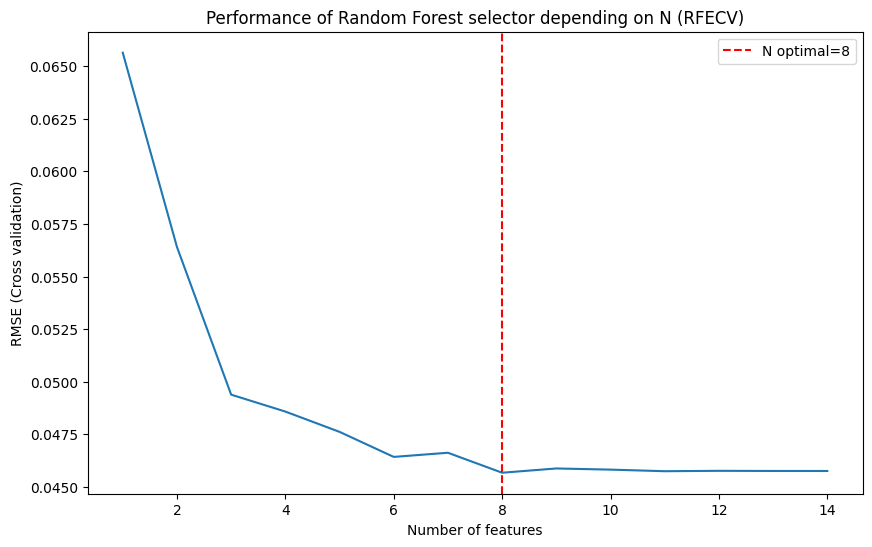

In [9]:

# Assuming it returns the actual RMSE values (since greater_is_better=False)
scores_rmse = -rfecv_selector.cv_results_['mean_test_score'] 
n_features_range = range(1, len(X_train_mrmr.columns) + 1)

# Création du graphique (nécessite matplotlib)
plt.figure(figsize=(10, 6))
plt.plot(n_features_range, scores_rmse)
plt.xlabel("Number of features")
plt.ylabel("RMSE (Cross validation)")
plt.title("Performance of Random Forest selector depending on N (RFECV)")
plt.axvline(x=N_optimal, color='r', linestyle='--', label=f'N optimal={N_optimal}')
plt.legend()
#plt.savefig("C:/Users/User/Desktop/GBIOM2/LELEC2870_Machine_learning/LELEC2870-Project/plots/performance_rf_selection.pdf")
plt.show()


--- Optimisation du MLP (Simple) ---

--- Optimisation du Multi-Layer Perceptron (MLP) ---
Début du tuning MLP...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 60), mlp__learning_rate_init=0.016, mlp__solver=adam; total time=   0.1s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 60), mlp__learning_rate_init=0.016, mlp__solver=adam; total time=   0.1s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 60), mlp__learning_rate_init=0.016, mlp__solver=adam; total time=   0.1s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 60), mlp__learning_rate_init=0.016, mlp__solver=adam; total time=   0.1s


[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(200, 120), mlp__learning_rate_init=0.016, mlp__solver=adam; total time=   0.3s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(200, 120), mlp__learning_rate_init=0.016, mlp__solver=adam; total time=   0.3s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(200, 120), mlp__learning_rate_init=0.016, mlp__solver=adam; total time=   0.4s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(200, 120), mlp__learning_rate_init=0.016, mlp__solver=adam; total time=   0.4s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(200, 120), mlp__learning_rate_init=0.016, mlp__solver=adam; total time=   0.4s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(200, 150), mlp__learning_rate_init=0.016, mlp__solver=adam; total time=   0.5s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(200, 150), mlp_

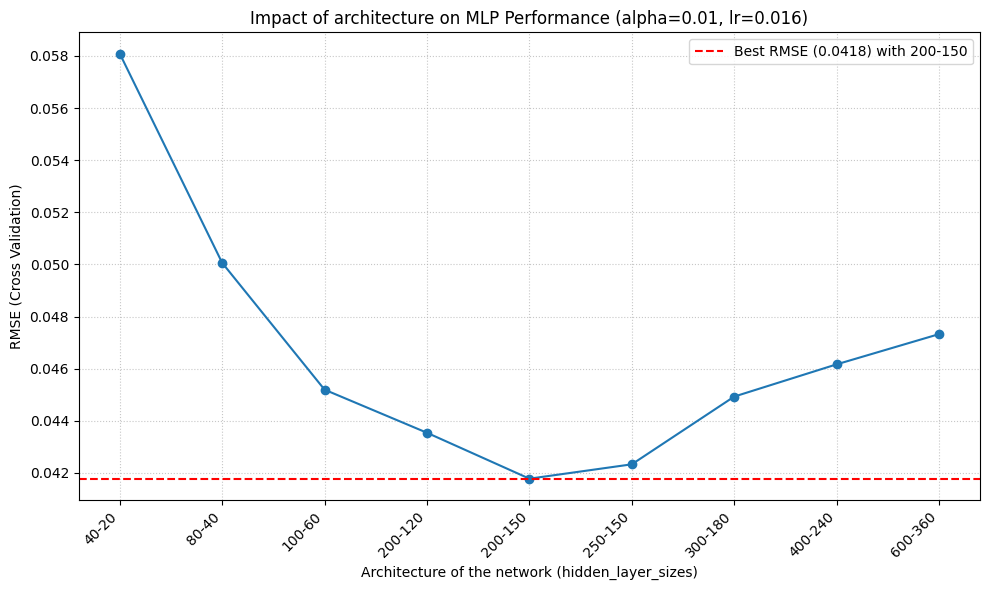

In [10]:
print("\n--- Optimisation du MLP (Simple) ---")

mlp_base_estimator = MLPRegressor(max_iter=500, random_state=42)

# Créer le Pipeline : Scaling puis MLP
pipe_mlp_fine_tune = Pipeline([
    ('scaler', StandardScaler()), 
    ('mlp', mlp_base_estimator) 
])
param_grid_mlp_final = {
    # Architectures à tester :
    # Essayer des configurations à 1 ou 2 couches
    # (40,) : 1 couche de 40 neurones (assez petite pour 12 features)
    # (40, 20) : 2 couches (40 puis 20)
    # (80, 40) : 2 couches plus larges
    'mlp__hidden_layer_sizes': [(40,20), (80, 40), (100, 60), (200, 120),(200,150), (250, 150),(300, 180),(400, 240), (600, 360)], 
    
    # Fonction d'activation (ReLU est standard et performante)
    'mlp__activation': ['relu'],
    
    # Terme de régularisation L2 (alpha)
    # Le MLP est sensible à l'overfitting, donc il faut tester la régularisation
    'mlp__alpha': [0.01],
    
    # Taux d'apprentissage initial
    'mlp__learning_rate_init': [0.016], 
    
    'mlp__solver': ['adam']
}
#Meilleurs hyperparamètres MLP : {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (400, 240), 'mlp__learning_rate_init': 0.01, 'mlp__solver': 'adam'}
# Fixer le nombre maximum d'itérations
# max_iter doit être suffisant pour que le réseau converge (souvent 500 ou 1000)
#mlp_estimator_final = MLPRegressor(max_iter=500, random_state=42)

mlp_grid_final = GridSearchCV(
    estimator=pipe_mlp_fine_tune,
    param_grid=param_grid_mlp_final,
    scoring=rmse_scorer_for_rfecv, # Utilisation du scorer RMSE négatif
    cv=5,
    n_jobs=-1,
    verbose=2
)

print("\n--- Optimisation du Multi-Layer Perceptron (MLP) ---")
print("Début du tuning MLP...")

# Entraînement et tuning sur les 12 caractéristiques
mlp_grid_final.fit(X_train_part2, y_train_ravel) 

# Extraction du résultat RMSE réel (inversion du signe)
best_rmse_val_mlp_final = -mlp_grid_final.best_score_ 

print(f"\nMeilleur RMSE (Validation Croisée MLP) : {best_rmse_val_mlp_final:.4f}")
print(f"Meilleurs hyperparamètres MLP : {mlp_grid_final.best_params_}")

# Sauvegarder le meilleur modèle pour la comparaison finale
best_mlp_model_final = mlp_grid_final.best_estimator_


import pandas as pd


# Assurez-vous d'utiliser l'objet mlp_grid après le fit final
results = pd.DataFrame(mlp_grid_final.cv_results_)

# Création d'une clé d'architecture simple pour le graphique
# Nous allons simplifier l'affichage du tuple (ex: (80, 40) devient '80-40')
def format_architecture(hls_tuple):
    if isinstance(hls_tuple, tuple):
        return '-'.join(map(str, hls_tuple))
    return str(hls_tuple)

results['Architecture_str'] = results['param_mlp__hidden_layer_sizes'].apply(format_architecture)

# Filtrer uniquement les résultats avec les meilleurs autres hyperparamètres 
# (activation='relu', alpha=0.015, learning_rate_init=0.015, solver='adam') 
# pour isoler l'effet de la taille des couches.

best_alpha = mlp_grid_final.best_params_['mlp__alpha']
best_lr = mlp_grid_final.best_params_['mlp__learning_rate_init']

filtered_results = results[
    (results['param_mlp__alpha'] == best_alpha) & 
    (results['param_mlp__learning_rate_init'] == best_lr) &
    (results['param_mlp__activation'] == 'relu') # Si vous n'avez testé que 'relu'
].copy()

# Calcul du RMSE réel (inverser le signe du score CV)
results['RMSE_CV'] = -results['mean_test_score']
plt.figure(figsize=(10, 6))

# Création du graphique : Architecture (X) vs RMSE (Y)
plt.plot(
    results['Architecture_str'], 
    results['RMSE_CV'], 
    marker='o', 
    linestyle='-', 
    color='#1f77b4'
)

# Marquage du meilleur score
min_rmse = results['RMSE_CV'].min()
best_arch = results.loc[results['RMSE_CV'].idxmin(), 'Architecture_str']
plt.axhline(y=min_rmse, color='r', linestyle='--', 
            label=f'Best RMSE ({min_rmse:.4f}) with {best_arch}')

plt.xlabel("Architecture of the network (hidden_layer_sizes)")
plt.ylabel("RMSE (Cross Validation)")
plt.title(f"Impact of architecture on MLP Performance (alpha={best_alpha}, lr={best_lr})")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Le score de généralisation final est du pour le mlp est : 0.0428


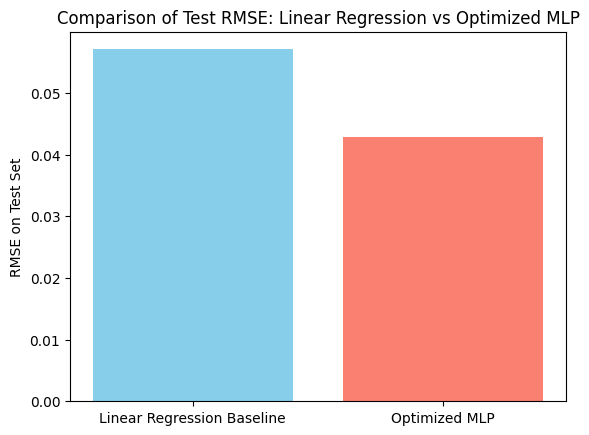

In [11]:

# Prédictions sur l'ensemble de Test
y_test_ravel = y_test.values.ravel() if hasattr(y_test, 'values') else y_test.ravel()
y_pred_test_mlp = best_mlp_model_final.predict(X_test_part2)

# Calcul des RMSE de Test
rmse_test_mlp = compute_rmse(y_pred_test_mlp, y_test_ravel)

# Modèle Linéaire (Baseline - Valeur obtenue en Partie 1)
linearBaseline = rmse_test_linear

# --- 3. Synthèse des Résultats Finals ---

#plot difference in test RMSE
print(f"Le score de généralisation final est du pour le mlp est : {rmse_test_mlp:.4f}")
labels = ['Linear Regression Baseline', 'Optimized MLP']
rmse_values = [linearBaseline, rmse_test_mlp]
plt.bar(labels, rmse_values, color=['skyblue', 'salmon'])
plt.ylabel('RMSE on Test Set')
plt.title('Comparison of Test RMSE: Linear Regression vs Optimized MLP')
plt.show()  

# Part3

Index(['age', 'blood pressure', 'calcium', 'cholesterol', 'hemoglobin',
       'height', 'potassium', 'profession', 'sarsaparilla',
       'smurfberry liquor', 'smurfin donuts', 'vitamin D', 'weight',
       'img_filename'],
      dtype='object')
Train: (1000, 8), Test: (500, 8)
t-SNE on pixel values


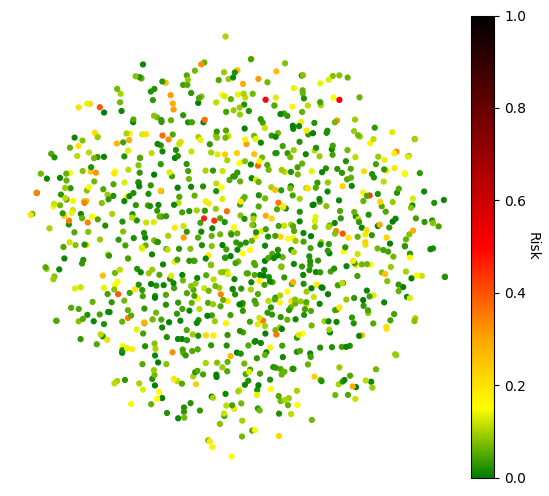

In [12]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)


y_test = pd.read_csv(labeled_data_path + 'y_test.csv', header=None)
y_train = pd.read_csv(labeled_data_path + 'y_train.csv', header=None)

X_train = X_train_clean
X_test = X_test_clean
X_unlabeled = X_unlabeled_clean

print(X_train.columns)
cols = [
    'blood pressure', 'cholesterol', 'weight', 'potassium',
    'sarsaparilla', 'vitamin D', 'age', 'hemoglobin'
]
X_train = pd.get_dummies(X_train, columns=['profession'])
X_test = pd.get_dummies(X_test, columns=['profession'])
X_unlabeled = pd.get_dummies(X_unlabeled, columns=['profession'])
# Ordinal encoding of consumption features
consumption_map = {
    'Very low': 1,
    'Low': 2,
    'Moderate': 3,
    'High': 4,
    'Very high': 5
}

for col in ['sarsaparilla', 'smurfberry liquor', 'smurfin donuts']:
    X_train[col] = X_train[col].map(consumption_map)
    X_test[col] = X_test[col].map(consumption_map)
    X_unlabeled[col] = X_unlabeled[col].map(consumption_map)


# Separate image filenames and tabular features
img_train = X_train["img_filename"].astype(str).values
img_test = X_test["img_filename"].astype(str).values

X_tab_train = X_train.drop(columns=["img_filename"])
X_tab_test = X_test.drop(columns=["img_filename"])

X_tab_train = X_tab_train[cols]
X_tab_test  = X_tab_test[cols]

y_train = y_train.values.ravel() if hasattr(y_train, 'values') else np.asarray(y_train).ravel()
y_test  = y_test.values.ravel()  if hasattr(y_test,  'values') else np.asarray(y_test).ravel()

print(f"Train: {X_tab_train.shape}, Test: {X_tab_test.shape}")

dataset_viz = CustomImageDataset(
    images=img_train, 
    images_directory="../data/data_labeled/Img_train", 
    target=y_train
)
print("t-SNE on pixel values")
visualize_dataset_tSNE(dataset_viz, extract_features=False, perplexity=30, random_state=42, zoom=2.0)




In [13]:
import os
import numpy as np

# Separate directories
IMAGE_DIR_TRAIN = "../data/data_labeled/Img_train"
IMAGE_DIR_TEST  = "../data/data_labeled/Img_test"

from sklearn.model_selection import KFold
from sklearn.base import clone
import numpy as np

# Ensure tabular train is a numpy array for easy indexing
X_tab_train_np = X_tab_train.values if hasattr(X_tab_train, "values") else np.asarray(X_tab_train)

n_features_list = [2, 3, 4, 5, 6, 7, 8]
kfold = KFold(n_splits=5, shuffle=True)

cv_summary = []

for nf in n_features_list:
    print(f"\n=== CV for n_features = {nf} ===")
    fold_rmses = []

    for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X_tab_train_np)):
        # Split tabular features (numpy) and targets/images by position
        X_tab_tr  = X_tab_train_np[train_idx]
        X_tab_val = X_tab_train_np[val_idx]
        y_tr      = y_train[train_idx]
        y_val     = y_train[val_idx]
        img_tr    = img_train[train_idx]
        img_val   = img_train[val_idx]

        # Train CNN on fold's train images
        cnn_cv = MyCNN(n_features=nf, n_epochs=60, batch_size=50, learning_rate=5e-4)
        _ = cnn_cv.fit(images=img_tr, y=y_tr, data_dir=IMAGE_DIR_TRAIN)

        # Extract features for train/val from TRAIN folder
        Z_tr  = cnn_cv.extract_features(images=img_tr,  data_dir=IMAGE_DIR_TRAIN)
        Z_val = cnn_cv.extract_features(images=img_val, data_dir=IMAGE_DIR_TRAIN)

        # Combine tabular + image features
        X_comb_tr  = np.hstack([X_tab_tr,  Z_tr])
        X_comb_val = np.hstack([X_tab_val, Z_val])

        # Fit cloned MLP and evaluate on val
        mlp_cv = clone(best_mlp_model_final)
        mlp_cv.fit(X_comb_tr, y_tr)
        y_pred_val = mlp_cv.predict(X_comb_val)

        rmse_val = compute_rmse(y_val, y_pred_val)
        fold_rmses.append(rmse_val)
        print(f"  Fold {fold_idx+1}: RMSE = {rmse_val:.4f}")

    rmse_mean = float(np.mean(fold_rmses))
    rmse_std  = float(np.std(fold_rmses))
    cv_summary.append({"n_features": nf, "rmse_mean": rmse_mean, "rmse_std": rmse_std})
    print(f"n_features={nf}: mean RMSE = {rmse_mean:.4f} ± {rmse_std:.4f}")


=== CV for n_features = 2 ===


Epoch  5 | Train RMSE: 0.0983 | Val RMSE: 0.0892
Epoch 10 | Train RMSE: 0.0859 | Val RMSE: 0.0878
Epoch 15 | Train RMSE: 0.0842 | Val RMSE: 0.0865
Epoch 20 | Train RMSE: 0.0804 | Val RMSE: 0.0843
Epoch 25 | Train RMSE: 0.0779 | Val RMSE: 0.0804
Epoch 30 | Train RMSE: 0.0754 | Val RMSE: 0.0783
Epoch 35 | Train RMSE: 0.0735 | Val RMSE: 0.0765
Epoch 40 | Train RMSE: 0.0728 | Val RMSE: 0.0759
Epoch 45 | Train RMSE: 0.0707 | Val RMSE: 0.0749
Epoch 50 | Train RMSE: 0.0699 | Val RMSE: 0.0738
Epoch 55 | Train RMSE: 0.0685 | Val RMSE: 0.0733
Epoch 60 | Train RMSE: 0.0671 | Val RMSE: 0.0732
  Fold 1: RMSE = 0.0341
Epoch  5 | Train RMSE: 0.0816 | Val RMSE: 0.0798
Epoch 10 | Train RMSE: 0.0783 | Val RMSE: 0.0768
Epoch 15 | Train RMSE: 0.0771 | Val RMSE: 0.0770
Epoch 20 | Train RMSE: 0.0750 | Val RMSE: 0.0745
Epoch 25 | Train RMSE: 0.0722 | Val RMSE: 0.0732
Epoch 30 | Train RMSE: 0.0675 | Val RMSE: 0.0705
Epoch 35 | Train RMSE: 0.0645 | Val RMSE: 0.0702
Epoch 40 | Train RMSE: 0.0611 | Val RMSE: 0.0

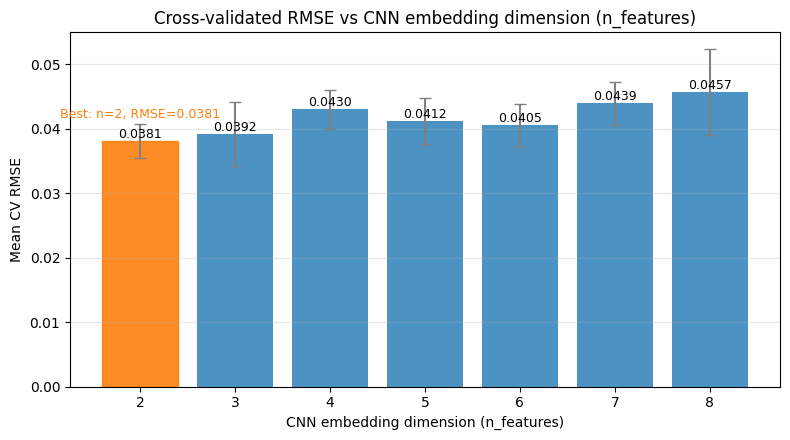

In [14]:
# Bar chart recap for cv_summary (mean RMSE with std error bars)


# cv_summary is a list of dicts: {"n_features": nf, "rmse_mean": ..., "rmse_std": ...}
cv_summary_sorted = sorted(cv_summary, key=lambda d: d["n_features"])
nfs   = [d["n_features"] for d in cv_summary_sorted]
means = [d["rmse_mean"]   for d in cv_summary_sorted]
stds  = [d["rmse_std"]    for d in cv_summary_sorted]

plt.figure(figsize=(8, 4.5))
bars = plt.bar(nfs, means, yerr=stds, capsize=4, color='tab:blue', alpha=0.8, ecolor='gray')

# Highlight the best bar
best_idx = int(min(range(len(means)), key=lambda i: means[i]))
bars[best_idx].set_color('tab:orange')
bars[best_idx].set_alpha(0.9)
plt.text(nfs[best_idx], means[best_idx] + stds[best_idx] + 0.0005,
         f"Best: n={nfs[best_idx]}, RMSE={means[best_idx]:.4f}",
         ha='center', va='bottom', fontsize=9, color='tab:orange')

# Annotate each bar with its mean
for x, y in zip(nfs, means):
    plt.text(x, y, f"{y:.4f}", ha='center', va='bottom', fontsize=9)

plt.title("Cross-validated RMSE vs CNN embedding dimension (n_features)")
plt.xlabel("CNN embedding dimension (n_features)")
plt.ylabel("Mean CV RMSE")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
# Select best n_features
best_entry = sorted(cv_summary, key=lambda d: d["rmse_mean"])[0]
best_nf = best_entry["n_features"]
print(f"\nBest N_FEATURES by CV: {best_nf} (mean RMSE = {best_entry['rmse_mean']:.4f} ± {best_entry['rmse_std']:.4f})")



Best N_FEATURES by CV: 2 (mean RMSE = 0.0381 ± 0.0026)


Epoch  5 | Train RMSE: 0.0807 | Val RMSE: 0.0815
Epoch 10 | Train RMSE: 0.0782 | Val RMSE: 0.0797
Epoch 15 | Train RMSE: 0.0747 | Val RMSE: 0.0763
Epoch 20 | Train RMSE: 0.0703 | Val RMSE: 0.0729
Epoch 25 | Train RMSE: 0.0661 | Val RMSE: 0.0709
Epoch 30 | Train RMSE: 0.0635 | Val RMSE: 0.0726
Epoch 35 | Train RMSE: 0.0596 | Val RMSE: 0.0694
Epoch 40 | Train RMSE: 0.0577 | Val RMSE: 0.0690
Epoch 45 | Train RMSE: 0.0557 | Val RMSE: 0.0695
Epoch 50 | Train RMSE: 0.0548 | Val RMSE: 0.0711
Epoch 55 | Train RMSE: 0.0528 | Val RMSE: 0.0713
Epoch 60 | Train RMSE: 0.0529 | Val RMSE: 0.0711


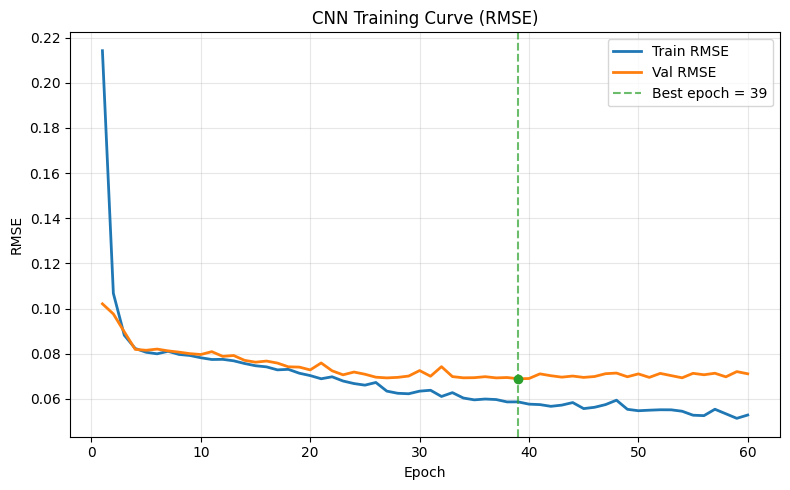

In [16]:

# Retrain on full TRAIN with best_nf and evaluate on TEST
cnn_best = MyCNN(n_features=best_nf, n_epochs=60, batch_size=50, learning_rate=5e-4)
history = cnn_best.fit(images=img_train, y=y_train, data_dir=IMAGE_DIR_TRAIN)
Z_train_best = cnn_best.extract_features(images=img_train, data_dir=IMAGE_DIR_TRAIN)
Z_test_best  = cnn_best.extract_features(images=img_test,  data_dir=IMAGE_DIR_TEST)

X_comb_train_best = np.hstack([X_tab_train_np, Z_train_best])
X_comb_test_best  = np.hstack([X_tab_test.values if hasattr(X_tab_test, "values") else np.asarray(X_tab_test), Z_test_best])

plot_cnn_training_curves(
    history,
    best_epoch=cnn_best.best_epoch,
    best_val_rmse=cnn_best.best_val_rmse,
    title="CNN Training Curve (RMSE)"
)


In [17]:
# Tabular-only baseline

rmse_tab_test = rmse_test_mlp 
print("Tabular-only MLP:")
print(f"  Test RMSE: {rmse_test_mlp:.4f}")

Tabular-only MLP:
  Test RMSE: 0.0428


t-SNE on extracted CNN features


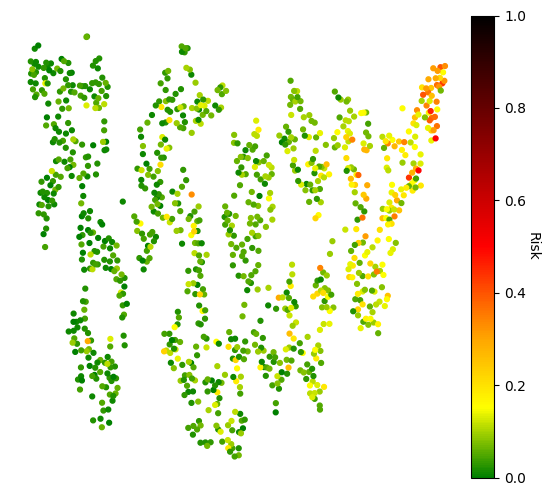

In [18]:
print("t-SNE on extracted CNN features")
visualize_dataset_tSNE(dataset_viz, extract_features=True, feature_extractor=cnn_best, perplexity=30, random_state=42, zoom=2.0)

Final test RMSE with N_FEATURES=2: 0.0356

Tabular + Image MLP:
  Test RMSE: 0.0356


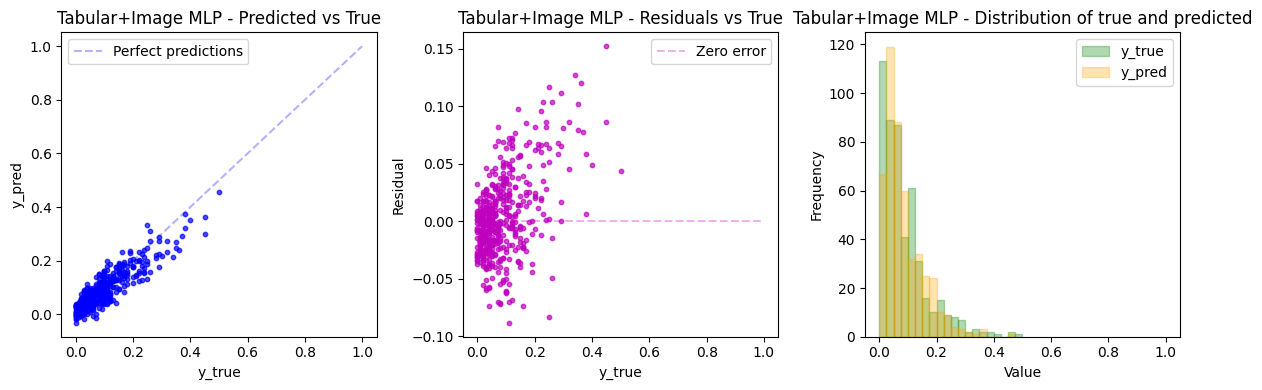

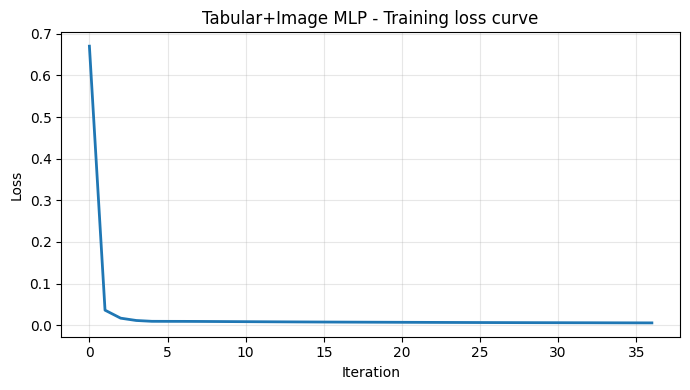

In [19]:
X_comb_train_best = np.hstack([X_tab_train_np, Z_train_best])
X_comb_test_best  = np.hstack([X_tab_test.values if hasattr(X_tab_test, "values") else np.asarray(X_tab_test), Z_test_best])

best_mlp_final_cv = clone(best_mlp_model_final)
best_mlp_final_cv.fit(X_comb_train_best, y_train)
y_pred_test_best = best_mlp_final_cv.predict(X_comb_test_best)
rmse_test_best = compute_rmse(y_test, y_pred_test_best)
print(f"Final test RMSE with N_FEATURES={best_nf}: {rmse_test_best:.4f}")

print("\nTabular + Image MLP:")
print(f"  Test RMSE: {rmse_test_best:.4f}")

# Residual/error analysis for combined model
visualize_regression_results(y_test, y_pred_test_best, title_prefix="Tabular+Image MLP - ")

# Optional: training loss curve for the fitted MLPRegressor (after combined fit)
plot_mlp_loss_curve(best_mlp_final_cv, title="Tabular+Image MLP - Training loss curve")

In [20]:
print("\n=======================================================")
print("Final Test Comparison (lower RMSE is better)")
print("-------------------------------------------------------")
print(f"Tabular-only MLP     : {rmse_tab_test:.4f}")
print(f"Tabular+Image MLP    : {rmse_test_best:.4f}")
print("=======================================================")

improvement = rmse_tab_test - rmse_test_best
print(f"Absolute improvement (RMSE): {improvement:+.4f}")


Final Test Comparison (lower RMSE is better)
-------------------------------------------------------
Tabular-only MLP     : 0.0428
Tabular+Image MLP    : 0.0356
Absolute improvement (RMSE): +0.0072


Cross-validating kernel features on TRAIN (fused with Tabular+CNN baseline)...

=== Kernel: blur_soft ===
  Fold 1: RMSE = 0.0404
  Fold 2: RMSE = 0.0402
  Fold 3: RMSE = 0.0356
  Fold 4: RMSE = 0.0381
  Fold 5: RMSE = 0.0368
Kernel blur_soft: mean CV RMSE = 0.0382 ± 0.0019

=== Kernel: sharpen ===
  Fold 1: RMSE = 0.0321
  Fold 2: RMSE = 0.0438
  Fold 3: RMSE = 0.0331
  Fold 4: RMSE = 0.0364
  Fold 5: RMSE = 0.0337
Kernel sharpen: mean CV RMSE = 0.0358 ± 0.0042

=== Kernel: laplacian_4 ===
  Fold 1: RMSE = 0.0336
  Fold 2: RMSE = 0.0377
  Fold 3: RMSE = 0.0350
  Fold 4: RMSE = 0.0334
  Fold 5: RMSE = 0.0350
Kernel laplacian_4: mean CV RMSE = 0.0349 ± 0.0015

=== Kernel: laplacian_8 ===
  Fold 1: RMSE = 0.0354
  Fold 2: RMSE = 0.0453
  Fold 3: RMSE = 0.0683
  Fold 4: RMSE = 0.0343
  Fold 5: RMSE = 0.0374
Kernel laplacian_8: mean CV RMSE = 0.0441 ± 0.0127

=== Kernel: sobel_x ===
  Fold 1: RMSE = 0.0359
  Fold 2: RMSE = 0.0392
  Fold 3: RMSE = 0.0411
  Fold 4: RMSE = 0.0345
  Fold 5: RM

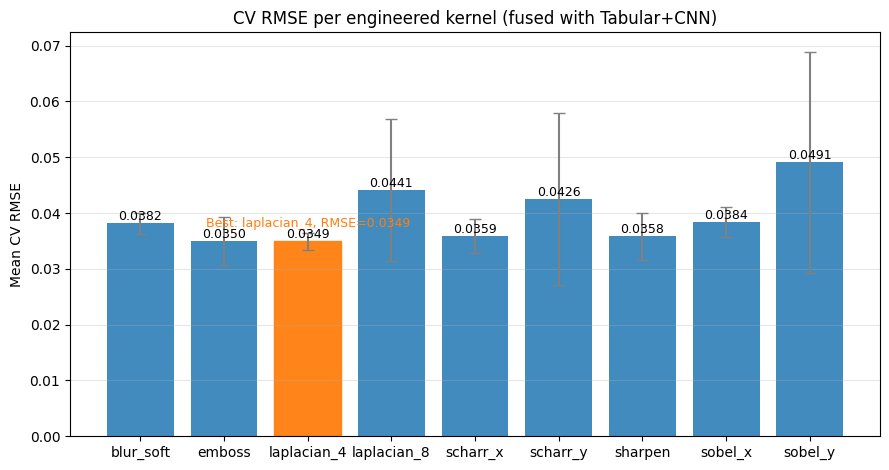

>>> Best kernel by CV: laplacian_4 (mean RMSE = 0.0349 ± 0.0015)

Final TEST comparison (lower RMSE is better)
Baseline Tabular+Image      : 0.0356
Tabular+Image+Best Kernel   : 0.0426
Δ vs baseline               : -0.0070


In [21]:
# Cell — Cross-validate engineered kernel features, pick best, then evaluate once on TEST

import numpy as np
from sklearn.model_selection import KFold
from sklearn.base import clone
import matplotlib.pyplot as plt

# Assumptions in scope:
# - KERNEL_BANK dict, functions: extract_engineered_kernel_features, compute_rmse
# - Precomputed baseline fused features: X_comb_train_best, X_comb_test_best
# - Best CNN model already trained: cnn_best (so Z_train_best, Z_test_best done)
# - y_train, y_test, img_train, img_test, IMAGE_DIR_TRAIN, IMAGE_DIR_TEST
# - best_mlp_model_final (pipeline to clone)

# 1) CV over kernels on TRAIN only
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
kernel_cv_summary = []  # list of dicts: {"kernel": name, "rmse_mean": ..., "rmse_std": ..., "rmses": [...]}

print("Cross-validating kernel features on TRAIN (fused with Tabular+CNN baseline)...\n")

for kname, kmat in KERNEL_BANK.items():
    fold_rmses = []
    print(f"=== Kernel: {kname} ===")
    for fold_idx, (tr_idx, val_idx) in enumerate(kfold.split(X_comb_train_best)):
        # Split baseline fused features and targets
        X_fused_tr  = X_comb_train_best[tr_idx]
        X_fused_val = X_comb_train_best[val_idx]
        y_tr        = y_train[tr_idx]
        y_val       = y_train[val_idx]

        # Split images for engineered features per fold
        img_tr_fold  = img_train[tr_idx]
        img_val_fold = img_train[val_idx]

        # Extract engineered features for this kernel (no unsharp/DoG) from TRAIN dir
        feats_tr, _  = extract_engineered_kernel_features(
            img_tr_fold, IMAGE_DIR_TRAIN, {kname: kmat},
            include_unsharp=False, include_dog=False
        )
        feats_val, _ = extract_engineered_kernel_features(
            img_val_fold, IMAGE_DIR_TRAIN, {kname: kmat},
            include_unsharp=False, include_dog=False
        )

        # Augment fused baseline with kernel stats
        X_tr_aug  = np.hstack([X_fused_tr,  feats_tr])
        X_val_aug = np.hstack([X_fused_val, feats_val])

        # Fit cloned MLP and compute RMSE on val
        model_cv = clone(best_mlp_model_final)
        model_cv.fit(X_tr_aug, y_tr)
        y_pred_val = model_cv.predict(X_val_aug)
        rmse_val = compute_rmse(y_val, y_pred_val)
        fold_rmses.append(rmse_val)
        print(f"  Fold {fold_idx+1}: RMSE = {rmse_val:.4f}")

    rmse_mean = float(np.mean(fold_rmses))
    rmse_std  = float(np.std(fold_rmses))
    kernel_cv_summary.append({"kernel": kname, "rmse_mean": rmse_mean, "rmse_std": rmse_std, "rmses": fold_rmses})
    print(f"Kernel {kname}: mean CV RMSE = {rmse_mean:.4f} ± {rmse_std:.4f}\n")

# 2) Plot CV recap (bar chart with std error bars), highlight best
kernel_cv_sorted = sorted(kernel_cv_summary, key=lambda d: d["kernel"])
names = [d["kernel"] for d in kernel_cv_sorted]
means = [d["rmse_mean"] for d in kernel_cv_sorted]
stds  = [d["rmse_std"]  for d in kernel_cv_sorted]

plt.figure(figsize=(9, 4.8))
bars = plt.bar(names, means, yerr=stds, capsize=4, color='tab:blue', alpha=0.85, ecolor='gray')
best_idx = int(min(range(len(means)), key=lambda i: means[i]))
bars[best_idx].set_color('tab:orange'); bars[best_idx].set_alpha(0.95)
plt.text(best_idx, means[best_idx] + stds[best_idx] + 0.0005,
         f"Best: {names[best_idx]}, RMSE={means[best_idx]:.4f}",
         ha='center', va='bottom', fontsize=9, color='tab:orange')
for i, m in enumerate(means):
    plt.text(i, m, f"{m:.4f}", ha='center', va='bottom', fontsize=9)
plt.title("CV RMSE per engineered kernel (fused with Tabular+CNN)")
plt.ylabel("Mean CV RMSE"); plt.grid(axis='y', alpha=0.3); plt.tight_layout(); plt.show()

# 3) Select best kernel by CV and evaluate ONCE on TEST
best_entry = sorted(kernel_cv_summary, key=lambda d: d["rmse_mean"])[0]
BEST_KERNEL_NAME = best_entry["kernel"]
BEST_KERNEL_MATRIX = KERNEL_BANK[BEST_KERNEL_NAME]
print(f">>> Best kernel by CV: {BEST_KERNEL_NAME} (mean RMSE = {best_entry['rmse_mean']:.4f} ± {best_entry['rmse_std']:.4f})")

# Build engineered features for TRAIN/TEST with ONLY the best kernel
best_train_feats, _ = extract_engineered_kernel_features(
    img_train, IMAGE_DIR_TRAIN, {BEST_KERNEL_NAME: BEST_KERNEL_MATRIX},
    include_unsharp=False, include_dog=False
)
best_test_feats, _ = extract_engineered_kernel_features(
    img_test, IMAGE_DIR_TEST, {BEST_KERNEL_NAME: BEST_KERNEL_MATRIX},
    include_unsharp=False, include_dog=False
)

X_aug_train = np.hstack([X_comb_train_best, best_train_feats])
X_aug_test  = np.hstack([X_comb_test_best,  best_test_feats])

# Fit on full TRAIN with augmented features and test once
augmented_mlp = clone(best_mlp_model_final)
augmented_mlp.set_params(mlp__max_iter=2000)
augmented_mlp.fit(X_aug_train, y_train)
y_pred_aug = augmented_mlp.predict(X_aug_test)
rmse_aug_test = compute_rmse(y_test, y_pred_aug)

print("\nFinal TEST comparison (lower RMSE is better)")
print(f"Baseline Tabular+Image      : {rmse_test_best:.4f}")
print(f"Tabular+Image+Best Kernel   : {rmse_aug_test:.4f}")
print(f"Δ vs baseline               : {rmse_test_best - rmse_aug_test:+.4f}")

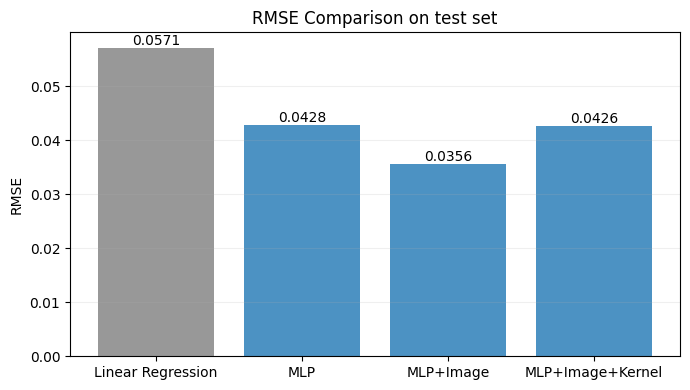

Absolute improvement MLP + Image + Kernel vs MLP: +0.0002
Absolute improvement MLP + Image + Kernel vs MLP + Image: -0.0070


In [22]:
plot_rmse_comparison(
    {   
        "Linear Regression": rmse_test_linear,
        "MLP": rmse_tab_test,
        "MLP+Image": rmse_test_best,
        "MLP+Image+Kernel": rmse_aug_test
    },
    title="RMSE Comparison on test set"
)

print("Absolute improvement MLP + Image + Kernel vs MLP:",
      f"{rmse_tab_test - rmse_aug_test:+.4f}")
print("Absolute improvement MLP + Image + Kernel vs MLP + Image:",
      f"{rmse_test_best - rmse_aug_test:+.4f}")

In [23]:
# Final cell — Produce y_pred.csv for unlabeled X.csv using best Tabular+Image model (no kernel)

import os
import numpy as np
import pandas as pd

# Columns used for tabular part (same as training)
cols = [
    'blood pressure', 'cholesterol', 'weight', 'potassium',
    'sarsaparilla', 'vitamin D', 'age', 'hemoglobin'
]

# 1) Build tabular matrix for unlabeled with the same columns and order
X_unlabeled_aligned = X_unlabeled.copy()
missing_cols = [c for c in cols if c not in X_unlabeled_aligned.columns]
if missing_cols:
    raise ValueError(f"Unlabeled dataframe is missing required columns: {missing_cols}")
X_tab_unlabeled = X_unlabeled_aligned[cols].values

# 2) Unlabeled image filenames and directory
img_unlabeled = X_unlabeled_aligned['img_filename'].astype(str).values
IMAGE_DIR_UNLABELED = "../data/data_unlabeled/Img"

# Optional: filter out rows with missing image files to keep arrays aligned
def exists_mask(filenames, directory):
    return np.array([os.path.exists(os.path.join(directory, f)) for f in filenames], dtype=bool)

mask_unl = exists_mask(img_unlabeled, IMAGE_DIR_UNLABELED)
if not mask_unl.all():
    missing = np.sum(~mask_unl)
    print(f"[WARN] {missing} unlabeled images not found in {IMAGE_DIR_UNLABELED}. Dropping those rows.")
    img_unlabeled   = img_unlabeled[mask_unl]
    X_tab_unlabeled = X_tab_unlabeled[mask_unl]

print("Unlabeled inputs:", X_tab_unlabeled.shape, "images:", len(img_unlabeled))

# 3) Extract CNN features for unlabeled images using the trained CNN from Part 3
Z_unlabeled = cnn_best.extract_features(images=img_unlabeled, data_dir=IMAGE_DIR_UNLABELED)
print("Z_unlabeled shape:", Z_unlabeled.shape)

# 4) Combine tabular and image features
X_comb_unlabeled = np.hstack([X_tab_unlabeled, Z_unlabeled])
print("X_comb_unlabeled:", X_comb_unlabeled.shape)

# IMPORTANT: fit a model on combined TRAIN features with the SAME CNN feature dimension
# Rebuild combined TRAIN with the same cnn_best (N_FEATURES=2)
Z_train_best = cnn_best.extract_features(images=img_train, data_dir=IMAGE_DIR_TRAIN)
X_comb_train_best = np.hstack([X_tab_train.values if hasattr(X_tab_train, "values") else np.asarray(X_tab_train),
                               Z_train_best])

from sklearn.base import clone
mlp_tabimg = clone(best_mlp_model_final)  # clone the pipeline
mlp_tabimg.fit(X_comb_train_best, y_train)  # fit on combined features (8 + 2 = 10)

# 5) Predict on unlabeled combined features
y_pred_unlabeled = mlp_tabimg.predict(X_comb_unlabeled)

# 6) Save to y_pred.csv (as required by the assignment)
out_df = pd.DataFrame({"y_pred": y_pred_unlabeled})
out_path = "y_pred.csv"  # exact filename requested
out_df.to_csv(out_path, index=False, header=False)
print(f"Saved predictions to: {out_path}")

Unlabeled inputs: (500, 8) images: 500
Z_unlabeled shape: (500, 2)
X_comb_unlabeled: (500, 10)
Saved predictions to: y_pred.csv
